In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large.tar.gz
Found and verified D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large already present - Skipping extraction of D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large.tar.gz.
['D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\A', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\B', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\C', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\D', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\E', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\F', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\G', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\data\\notMNIST_large\\H', 'D:\\1_Workspaces\\UNDER_VCS\\github\\1_ML_NN\\python_with_math\\d

In [4]:
Image(filename=data_root+'\\notMNIST_large\\A\\a2F6b28udHRm.png') 

In [5]:
Image(filename=data_root+'\\notMNIST_large\\A\\a3JvZWdlciAwNl81NS50dGY=.png')

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder) ## it counts all files in the folder
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32) #it creates a 3d array
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:                #for each letter's folder
    set_filename = folder + '.pickle'        #create a file with appropriate letter's name
    dataset_names.append(set_filename)       #add them to a returned set
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class) #it loads a letter from folder to a 3D array
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)    #it dumps a 3D array to a file
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000) # it creates 3D array for all letters in a train dataset
test_datasets = maybe_pickle(test_folders, 1800)# it creates 3D array for all letters in a test dataset

D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\A.pickle already present - Skipping pickling.
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\B.pickle already present - Skipping pickling.
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\C.pickle already present - Skipping pickling.
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\D.pickle already present - Skipping pickling.
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\E.pickle already present - Skipping pickling.
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\F.pickle already present - Skipping pickling.
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\G.pickle already present - Skipping pickling.
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\H.pickle already present - Skipping pickling.
D:\1_Wor

In [10]:
a_picle_filename = train_datasets[0]
print (a_picle_filename)
input = open(a_picle_filename, 'rb')
_3Darray_A = pickle.load(input)
input.close()
print (_3Darray_A.ndim, '\t', _3Darray_A.shape)
print ('============================================= point to print in a screen of image at index 0 =========================')
print (_3Darray_A[0][0][4])
print ('============================================= array[0] of pixels of image at index 0 =================================')
print (_3Darray_A[0][0])
print ('============================================= array[1] of pixels of image at index 0 =================================')
print (_3Darray_A[0][1])
print ('============================================= Image at index 0 =======================================================')
print (_3Darray_A[0].shape, '\n', _3Darray_A[0]) #28 * 28 features
print ('============================================= Full set of images =====================================================')
#print (_3Darray_A)

D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\A.pickle
3 	 (52909, 28, 28)
============================================= point to print in a screen of image at index 0 =========================
-0.484314
============================================= array[0] of pixels of image at index 0 =================================
[-0.5        -0.5        -0.5        -0.5        -0.48431373 -0.5
 -0.19019608  0.46862745  0.49215686  0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5         0.5
  0.49215686  0.46862745 -0.19019608 -0.5        -0.48431373 -0.5        -0.5
 -0.5        -0.5       ]
============================================= array[1] of pixels of image at index 0 =================================
[-0.5        -0.5        -0.5        -0.48823529 -0.5        -0.30392158
  0.43333334  0.5         0.49215686  0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5        

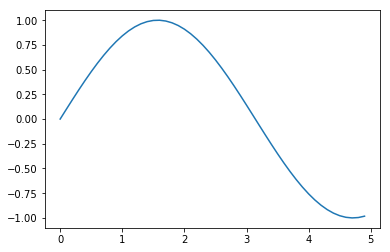

In [11]:
# here is an example of plotting with matplotlib
x = np.arange(0, 5, 0.1);
y = np.sin(x)
plt.plot(x, y)

In [79]:
# here is a pictures from picle written to a folder
for i in range (10):
    x = _3Darray_A[i]
    print (i, " = ", x.shape)
    imageio.imwrite(data_root + '\\imageio\\picle_A_' + str(i) + '.png', x[:])

b_picle_filename = train_datasets[1]
print (b_picle_filename)
input = open(b_picle_filename, 'rb')
_3Darray_B = pickle.load(input)
input.close()
# here is a pictures from picle written to a folder
for i in range (10):
    x = _3Darray_B[i]
    print (i, " = ", x.shape)
    imageio.imwrite(data_root + '\\imageio\\picle_B_' + str(i) + '.png', x[:])

0  =  (28, 28)
1  =  (28, 28)
2  =  (28, 28)
3  =  (28, 28)
4  =  (28, 28)
5  =  (28, 28)
6  =  (28, 28)
7  =  (28, 28)
8  =  (28, 28)
9  =  (28, 28)
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST_large\B.pickle


C:\Other_IT\Anaconda\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from float32 to uint8, range [-0.5, 0.5]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


0  =  (28, 28)
1  =  (28, 28)
2  =  (28, 28)
3  =  (28, 28)
4  =  (28, 28)
5  =  (28, 28)
6  =  (28, 28)
7  =  (28, 28)
8  =  (28, 28)
9  =  (28, 28)


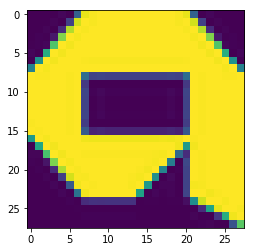

In [13]:
# here is a picture from pilce which is shown direct here:
y = _3Darray_A[0]
plt.imshow(y)

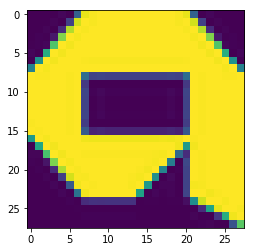

In [14]:
# here is a real image as seen at the time when it was read and written to a 3dArray. Notice it the same as previous.
image_data = (imageio.imread(data_root + '\\notMNIST_large\\A\\a29ydW5pc2hpLnR0Zg==.png').astype(float) - 
                    pixel_depth / 2) / pixel_depth
plt.imshow(image_data)

In [15]:
#it creates an empty n-dimensional arrays
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

# it creates a single 3dArray from all GIVEN picle files
def merge_datasets(pickle_files, train_size, valid_size=0):
  print ('====================== merging =======================================')
  num_classes = len(pickle_files)

  valid_dataset, valid_labels = make_arrays(valid_size, image_size)  #empty array
  train_dataset, train_labels = make_arrays(train_size, image_size)  #empty array

  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes

  print ('valid_size ', valid_size, '\n')
  print ('train_size ', train_size, '\n', 'num_classes', num_classes, '\n')
  print ('vsize_per_class ', vsize_per_class, '\n', 'tsize_per_class', tsize_per_class, '\n\n')
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class

  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
        
# it returns 4 objects!!
  return valid_dataset, valid_labels, train_dataset, train_labels
            
#SUBJECT TO CHANGE accordingly to task 6            
train_size = 10000
valid_size = 1000
test_size = 1000

# it uses all 4 objects
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)

# it uses only 2 last objects
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

====================== merging =======================================
valid_size  1000 

train_size  10000 
 num_classes 10 

vsize_per_class  100 
 tsize_per_class 1000 


====================== merging =======================================
valid_size  0 

train_size  1000 
 num_classes 10 

vsize_per_class  0 
 tsize_per_class 100 


Training: (10000, 28, 28) (10000,)
Validation: (1000, 28, 28) (1000,)
Testing: (1000, 28, 28) (1000,)


In [17]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [18]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (10000, 28, 28) (10000,)
Validation: (1000, 28, 28) (1000,)
Testing: (1000, 28, 28) (1000,)


In [19]:
# it dumps a big 3D array to a big file. Note - each time we have a RANDOMLY SHUFFLED array 
# so we HAVE TO dump it without checking

pickle_file = os.path.join(data_root, 'notMNIST.pickle')

def dumpBigShuffledArray():
    try:
        f = open(pickle_file, 'wb')
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

In [20]:
dumpBigShuffledArray()

# but if you want to skip - just jump to the next cell

In [21]:
# you can check the file existance
# don't worry to run this cell just because it cheks a file firstly

if os.path.exists(pickle_file):
      # You may override by setting force=True.
      statinfo = os.stat(pickle_file)
      print('Compressed pickle size:', statinfo.st_size)
      print('%s already present - Skipping pickling.' % pickle_file)      
else:
  dumpBigShuffledArray()

Compressed pickle size: 37680493
D:\1_Workspaces\UNDER_VCS\github\1_ML_NN\python_with_math\data\notMNIST.pickle already present - Skipping pickling.


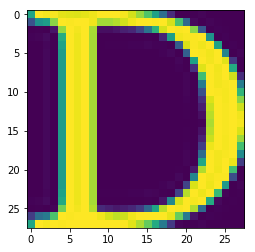

In [22]:
#it checks a picture from a big 3dArray. IT ALWAYS WILL BE A DIFFERENT PICTURE.
input = open(pickle_file, 'rb')
_3Darray_BIG = pickle.load(input)
input.close()
train_dataset_my = _3Darray_BIG['train_dataset']
img_overlapped = train_dataset_my[10]
plt.imshow(img_overlapped)

In [23]:
NEURAL_OUTPUT_CLASSES = 10;
VECTOR_DIMENSION = 784; #square 28*28 as from data set -> array 784 items
            #first layer is an image 28x28 pixels -> 784 pixels
            #last layer is a digit from 0 to 9, the output is a one dimensional vector of size 10.
            #The values of output vector are probabilities that the input is likely to be one of those digits.
            #layers = new int[]{VECTOR_DIMENSION, 128, 64, NEURAL_OUTPUT_CLASSES};
#log_regr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                   #intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', 
                   #max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1);
log_regr = LogisticRegression();

In [24]:
nsamples, nx, ny = train_dataset.shape
train_dataset_reshaped = train_dataset.reshape((nsamples,nx*ny))
print (train_dataset_reshaped.shape)

(10000, 784)


In [25]:
log_regr.fit(train_dataset_reshaped,train_labels);

In [26]:
#reshapint validation dataset
nsamples, nx, ny = valid_dataset.shape
valid_dataset_reshaped = valid_dataset.reshape((nsamples,nx*ny))
print (valid_dataset_reshaped.shape)

(1000, 784)


In [30]:
score = log_regr.score(valid_dataset_reshaped, valid_labels);
print (score); #0.804

0.804


(784,)


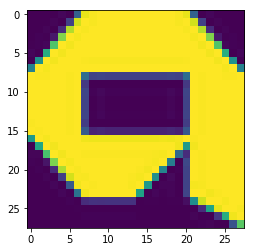

In [48]:
#read a real inage and reshape it for predicting
image_data_1 = imageio.imread(data_root + '\\notMNIST_large\\A\\a29ydW5pc2hpLnR0Zg==.png').astype(float);
nx_img, ny_img = image_data_1.shape;
reshaped_image = image_data_1.reshape(nx_img*ny_img);
wtf = train_dataset_my[10];
plt.imshow(image_data_1);
#plt.imshow(reshaped_image); #doent work - good
print (reshaped_image.shape);

In [62]:
res = reshaped_image.reshape(-784, 784);

array_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'];
predicted = log_regr.predict(res);
print (predicted);
print (array_letters[predicted])

[6]
g


C:\Other_IT\Anaconda\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(784,)


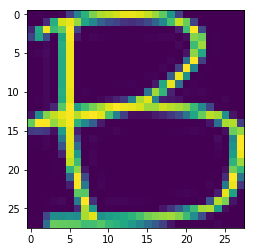

In [80]:
#read a real image and reshape it for predicting
image_data_2 = imageio.imread(data_root + '\\imageio\\picle_B_9.png').astype(float);
nx_img, ny_img = image_data_2.shape;
reshaped_image_2 = image_data_2.reshape(nx_img*ny_img);
plt.imshow(image_data_2);
#plt.imshow(reshaped_image); #doesn't work - good
print (reshaped_image_2.shape);

In [81]:
res_2 = reshaped_image_2.reshape(-784, 784);
predicted_2 = log_regr.predict(res_2);
print (predicted_2);
print (array_letters[predicted_2])

[1]
b


C:\Other_IT\Anaconda\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
